In [2]:
import pandas as pd
import geopandas as gpd
from pyproj import Transformer
import networkx as nx
import folium
from folium.plugins import HeatMap
import branca.colormap as cm
import matplotlib.pyplot as plt

In [48]:
# Convert Node Coordinates from Illinois to Long/Lat
node_file = "ChicagoSketch_node.tntp"
nodes = []
reading_date = False
with open(node_file, "r") as file:
    for line in file:
        line = line.split(";")[0]
        # print(line)
        if line.startswith("node"):
            reading_date = True
            continue
        if not reading_date or line.startswith("~") or line == "":
            continue
        parts = line.split()
        if len(parts) >= 3:
            node_id, x, y = int(parts[0]), float(parts[1]), float(parts[2])
            nodes.append((node_id, x, y))

# Convert to DataFrame
df_nodes = pd.DataFrame(nodes, columns=["Node", "X", "Y"])

# Convert Illinois State Plane (EPSG:3435) to Latitude/Longitude (EPSG:4326)
transformer = Transformer.from_crs("EPSG:26771", "EPSG:4326", always_xy=True)
df_nodes["Lon"], df_nodes["Lat"] = zip(*df_nodes.apply(lambda row: transformer.transform(row["X"], row["Y"]), axis=1))

print("Original Coordinates (Illinois State Plane):")
print(df_nodes[["X", "Y"]].head())

print("\nTransformed Coordinates (WGS84 - Lat/Lon):")
print(df_nodes[["Lat", "Lon"]].head())


# Check the first few converted coordinates
print(df_nodes.head())

# Convert to GeoDataFrame
gdf_nodes = gpd.GeoDataFrame(df_nodes, geometry=gpd.points_from_xy(df_nodes["Lon"], df_nodes["Lat"]), crs="EPSG:4326")

gdf_nodes.to_csv("chicago_nodes_transformed.csv", index=False)

Original Coordinates (Illinois State Plane):
          X          Y
0  690309.0  1976022.0
1  683649.0  1973025.0
2  693306.0  1963368.0
3  686313.0  1958373.0
4  696636.0  1946718.0

Transformed Coordinates (WGS84 - Lat/Lon):
         Lat        Lon
0  42.089782 -87.632304
1  42.081706 -87.656926
2  42.054992 -87.621652
3  42.041443 -87.647547
4  42.009228 -87.609911
   Node         X          Y        Lon        Lat
0     1  690309.0  1976022.0 -87.632304  42.089782
1     2  683649.0  1973025.0 -87.656926  42.081706
2     3  693306.0  1963368.0 -87.621652  42.054992
3     4  686313.0  1958373.0 -87.647547  42.041443
4     5  696636.0  1946718.0 -87.609911  42.009228


   init_node  term_node  capacity   length  free_flow_time     b  power  \
0          1        547   49500.0  0.86267             0.0  0.15    4.0   
1          2        548   49500.0  0.86267             0.0  0.15    4.0   
2          3        549   49500.0  0.86267             0.0  0.15    4.0   
3          4        550   49500.0  0.86267             0.0  0.15    4.0   
4          5        551   49500.0  0.86267             0.0  0.15    4.0   

   speed  toll  
0    0.0   0.0  
1    0.0   0.0  
2    0.0   0.0  
3    0.0   0.0  
4    0.0   0.0  


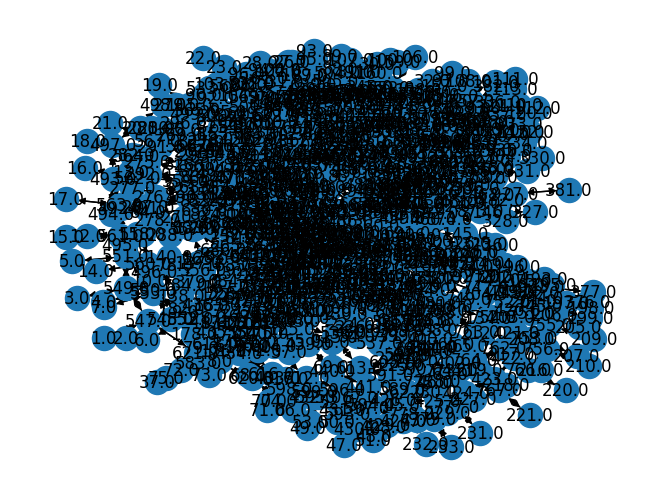

In [4]:
# Load the Road Network (ChicagoSketch_net.tntp)
# SETUP FOR NETWORK MEASURES
network_file = "ChicagoSketch_net.tntp"
edges = []
reading_data = False

with open(network_file, "r") as file:
    for line in file:
        if line.startswith("<END OF METADATA>"):
            reading_data = True
            continue
        if not reading_data or line.startswith("~") or line.startswith("<") or line == "":
            continue
        line = line.split(";")[0]
        parts = line.split()
        if len(parts) >= 6:
            init_node, term_node = int(parts[0]), int(parts[1])
            capacity, length, free_flow_time, b, power, speed, toll = map(float, parts[2:9])
            edges.append((init_node, term_node, {"capacity": capacity, "length": length, "free_flow_time": free_flow_time, "b": b, "power": power, "speed": speed, "toll": toll}))


edges_df = pd.DataFrame(edges, columns=["init_node", "term_node", "attributes"])
attributes_expanded = edges_df["attributes"].apply(pd.Series)
edges_df = pd.concat([edges_df[["init_node", "term_node"]], attributes_expanded], axis=1)

print(edges_df.head())

G = nx.DiGraph()
for _, row in edges_df.iterrows():
    G.add_edge(
        row['init_node'],
        row['term_node'],
        weight=row['length']  # 'Length' is travel time or distance
    )
nx.draw(G, with_labels=True)




In [49]:
def add_edge_to_graph(G, nodeA, nodeB, attr, df_nodes=df_nodes, df_edges=edges_df):
    """
    nodeA: (lon, lat) coordinates of node A
    nodeB: (lon, lat) coordinates of node B
    attr: {'capacity': capacity, 'length': length, 'free_flow_time': free_flow_time, 'b': b, 'power': power, 'speed': speed, 'toll': toll}
    """
    transformer = Transformer.from_crs("EPSG:4326", "EPSG:26771", always_xy=True)

    # adding nodeA to df_nodes
    x_val, y_val = transformer.transform(nodeA[0], nodeA[1])
    nodeA_id = len(df_nodes)
    nodeB_id = nodeA_id + 1
    df_nodes.loc[nodeA_id] = [len(df_nodes), x_val, y_val, nodeA[0], nodeA[1]]

    # adding nodeB to df_nodes
    x_val, y_val = transformer.transform(nodeB[0], nodeB[1])
    
    df_nodes.loc[nodeB_id)] = [len(df_nodes), x_val, y_val, nodeB[0], nodeB[1]]
    

    print(nodeA, nodeB)
    print(df_nodes[Node])
    # adding edge to df_edges
    # df_edges.loc[len(df_edges)] = [nodeA, nodeB, attr]
    # 
    # print(df_edges.head())
    # adding edge to graph
    # row = df_edges[len(df_edges)]
    
    G.add_edge(
        row['init_node'],
        row['term_node'], 
        weight=row['length']  # 'Length' is travel time or distance
        )
    


nodeA = (41.9742, -87.9073)  # Chicago
nodeB = (41.7868, -87.7522)  # Chicago
attr = {'capacity': 0, 'length': 1, 'free_flow_time': 0, 'b': 0, 'power': 0, 'speed': 0, 'toll': 0}


    

SyntaxError: closing parenthesis ')' does not match opening parenthesis '[' (3365886271.py, line 18)

In [5]:
# Create Chicago map

center_lat = df_nodes["Lat"].mean()
center_lon = df_nodes["Lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)


print(center_lat, center_lon)
# Add roads to map
for edge in edges:
    start, end, attr = edge
    lon1, lat1 = df_nodes.loc[df_nodes["Node"] == start, ["Lon", "Lat"]].values[0]
    lon2, lat2 = df_nodes.loc[df_nodes["Node"] == end, ["Lon", "Lat"]].values[0]

    # Color roads based on free-flow time
    color = "green" if attr["free_flow_time"] < 5 else "orange" if attr["free_flow_time"] < 10 else "red"

    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color=color, weight=3, opacity=0.7).add_to(m)

# Display map
m.save("chicago_map.html")

m


41.91232895468069 -87.95152438099583


In [6]:
# Mean Degree
# 2E / N 
N = 933
E = 2950
mean_degree = 2 * E / N
mean_degree

6.323687031082529

Mean Degree of approximately 6

This is a directed network. Each road segment counts as two directed edges if traffic can flow both ways
Road networks in urban areas often have degrees around 4–8 because intersections frequently connect multiple roads.
A mean degree around 6 indicates that intersections are generally connected to around 3 roads (considering incoming and outgoing separately).


We can check for a giant component

if most nodes belong to a giant component, then the transit network is largely reachable as a whole
There are minimal isolated sub-networks – most routes interlink, which is expected in a comprehensive city transit system. This ensures that, in principle, a rider can get from almost any stop to another

Betweenness Centrality: 

Betweenness measures how often a node or link lies on shortest paths between other nodes

We found that a small subset of critical nodes and links carry a disproportionately high fraction of shortest paths.

FINDINGS:
Central Hub Nodes: Nodes in downtown Chicago emerge with the highest betweenness centrality. This is intuitive – many trips from one outlying area to another must “pass through” downtown. For example, a central station where multiple L train lines and bus routes intersect will lie on many shortest paths connecting different sides of the city. These downtown nodes effectively act as bridges between the network’s outer parts​


Key Corridor Links: Similarly, certain rail lines and bus corridors have very high edge betweenness. For instance, the main north-south rail line and major crosstown bus arteries likely rank top in betweenness, as they funnel numerous trips. These are the core transit corridors – if disrupted, many origin-destination pairs would be affected. Identifying such links is crucial for prioritizing maintenance and adding redundancy. In summary, betweenness centrality pinpoints the “choke points” of Chicago transit, highlighting corridors like those leading into downtown (where multiple routes converge) as critical arteries for network flow.


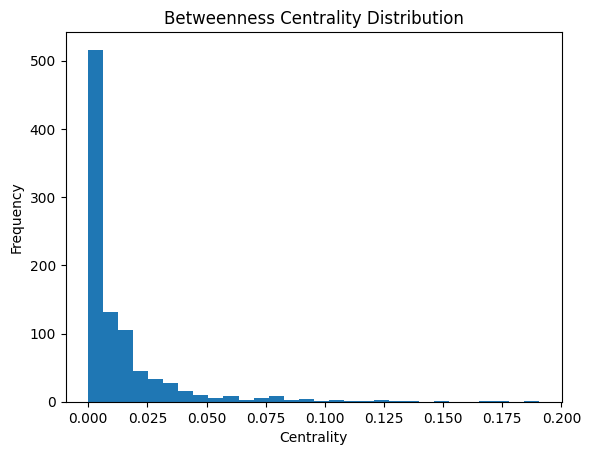

True
False


In [7]:
# Betweenness Centrality
betweenness = nx.betweenness_centrality(G, weight='Length', normalized=True)
centrality_df = pd.DataFrame.from_dict(betweenness, orient='index', columns=['betweenness_centrality'])
centrality_df.reset_index(inplace=True)
centrality_df.columns = ['Node', 'Betweenness Centrality']
centrality_df.sort_values(by='Betweenness Centrality', ascending=False, inplace=True)
centrality_df.to_csv("centrality.csv", index=False)

plt.hist(centrality_df['Betweenness Centrality'], bins=30)
plt.title('Betweenness Centrality Distribution')
plt.xlabel('Centrality')
plt.ylabel('Frequency')
plt.show()

# plot shows that there are few highly central nodes and many peripheral nodes

# The central nodes are really important to connectivity
print(nx.is_strongly_connected(G))
top_nodes = centrality_df.head(5)['Node'].tolist()
G_removed = G.copy()
G_removed.remove_nodes_from(top_nodes)
print(nx.is_strongly_connected(G_removed))


# marking the nodes with highest betweenness on map

# Merge centrality data with node coordinates
centrality_coords = centrality_df.merge(df_nodes, left_on='Node', right_on='Node')

# Create map centered on Chicago Sketch dataset
center_lat = df_nodes["Lat"].mean()
center_lon = df_nodes["Lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add roads to map (without color-coding)
for edge in edges:
    start, end, attr = edge
    lon1, lat1 = df_nodes.loc[df_nodes["Node"] == start, ["Lon", "Lat"]].values[0]
    lon2, lat2 = df_nodes.loc[df_nodes["Node"] == end, ["Lon", "Lat"]].values[0]

    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color="gray", weight=2, opacity=0.5).add_to(m)

# Add markers for top 10 nodes by betweenness centrality
top_nodes = centrality_coords.head(30)

for _, row in top_nodes.iterrows():
    folium.Marker(
        location=[row['Lat'], row['Lon']],
        popup=f"Node: {row['Node']}<br>Betweenness: {row['Betweenness Centrality']:.4f}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

# Save and display map
m.save("chicago_betweenness_map.html")
m

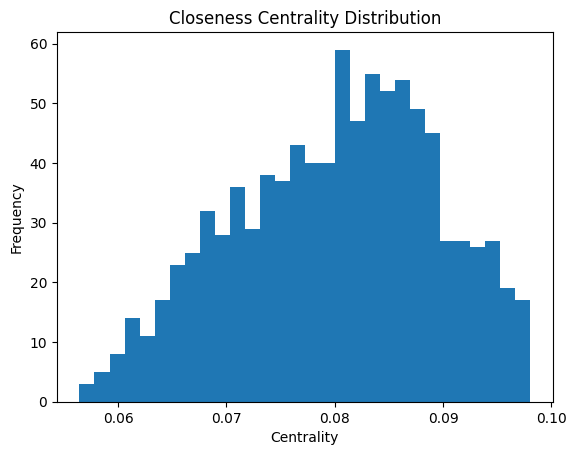

Network strongly connected: True
Network strongly connected after removing top nodes: False


In [8]:
# Compute Closeness Centrality

closeness = nx.closeness_centrality(G)
closeness_centrality_df = pd.DataFrame.from_dict(closeness, orient='index', columns=['Closeness Centrality'])
closeness_centrality_df.reset_index(inplace=True)
closeness_centrality_df.rename(columns={'index': 'Node'}, inplace=True)
closeness_centrality_df.sort_values(by='Closeness Centrality', ascending=False, inplace=True)
closeness_centrality_df.to_csv("closeness_centrality.csv", index=False)

# Plot histogram for Closeness Centrality distribution
plt.hist(closeness_centrality_df['Closeness Centrality'], bins=30)
plt.title('Closeness Centrality Distribution')
plt.xlabel('Centrality')
plt.ylabel('Frequency')
plt.show()

# Check network connectivity before and after removing top central nodes
print("Network strongly connected:", nx.is_strongly_connected(G))
top_nodes = closeness_centrality_df.head(5)['Node'].tolist()
G_removed = G.copy()
G_removed.remove_nodes_from(top_nodes)
print("Network strongly connected after removing top nodes:", nx.is_strongly_connected(G_removed))

# Merge centrality data with node coordinates
centrality_coords = closeness_centrality_df.merge(df_nodes, on='Node')

# Create map centered on Chicago Sketch dataset
center_lat = df_nodes["Lat"].mean()
center_lon = df_nodes["Lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Add roads to map
for edge in edges:
    start, end = edge[0], edge[1]
    lon1, lat1 = df_nodes.loc[df_nodes["Node"] == start, ["Lon", "Lat"]].values[0]
    lon2, lat2 = df_nodes.loc[df_nodes["Node"] == end, ["Lon", "Lat"]].values[0]

    folium.PolyLine([(lat1, lon1), (lat2, lon2)], color="gray", weight=2, opacity=0.5).add_to(m)

# Add markers for top 30 nodes by Closeness Centrality
top_nodes_coords = centrality_coords.head(30)

for _, row in top_nodes_coords.iterrows():
    folium.Marker(
        location=[row['Lat'], row['Lon']],
        popup=f"Node: {row['Node']}<br>Closeness: {row['Closeness Centrality']:.4f}",
        icon=folium.Icon(color="red", icon="info-sign")
    ).add_to(m)

# Save map to HTML
m.save("chicago_closeness_map.html")
m

In [9]:
# Heat map visualization of closess centrality

# Create map centered on Chicago Sketch dataset
center_lon = df_nodes["Lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# # Add roads to map
# for edge in edges:
#     start, end = edge[0], edge[1]
#     lon1, lat1 = df_nodes.loc[df_nodes["Node"] == start, ["Lon", "Lat"]].values[0]
#     lon2, lat2 = df_nodes.loc[df_nodes["Node"] == end, ["Lon", "Lat"]].values[0]

#     folium.PolyLine([(lat1, lon1), (lat2, lon2)], color="gray", weight=2, opacity=0.5).add_to(m)

# Prepare HeatMap data for closeness centrality
heat_data = [[row['Lat'], row['Lon'], row['Closeness Centrality']] for _, row in centrality_coords.iterrows()]

# Add a legend (using custom HTML)
from branca.element import Template, MacroElement

legend_html = '''
<div style="position: fixed; 
            bottom: 50px; left: 50px; width: 180px; height: 90px; 
            background-color: white; z-index:9999; font-size:14px;
            border:2px solid grey; padding: 10px;">
    <b>Closeness Centrality</b><br>
    <div>
        <i style="background: linear-gradient(to right, red, orange, yellow, green);"></i><br>
    </div>
</div>
'''

m.get_root().html.add_child(folium.Element(legend_html))


# Add HeatMap layer
HeatMap(heat_data, radius=8, blur=6, max_zoom=13).add_to(m)

# Save map to HTML
m.save("chicago_closeness_heatmap.html")
m


Closeness Centrality Interpretation
Distribution of Closeness Centrality:
Normal Shaped Distribution: most nodes have medium closeness centrality

Map: 
This map highlights the top nodes based on closeness centrality with markers:

Clustered Markers (around downtown Chicago area):
Concentration indicates that the central region is densely interconnected.
Nodes in this region have the highest accessibility to other nodes, representing significant transportation hubs or intersections.
Peripheral markers (fewer):
A few nodes located further from the center (Aurora, outskirts) are also marked. They might represent critical suburban hubs or junction points connecting outer regions with the central network.
These nodes are strategically important in efficiently connecting remote regions to the main metropolitan area.



Heatmap:
Heatmap visualizes the closeness centrality of the nodes in your Chicago transportation network. Here’s a clear interpretation and analysis of your results:

Interpretation of the Heatmap:
High Centrality (Red Areas):

Nodes in these areas can reach all other nodes efficiently.
These areas represent highly connected or central regions of the network, likely major transport hubs or critical intersections.
In Chicago, this usually corresponds to densely populated, infrastructure-heavy downtown regions or major highway junctions.
Medium Centrality (Yellow to Orange):

Nodes have moderate ease of reaching others, typically areas surrounding the core network or along primary arterial roads.
Low Centrality (Green/Blue Areas):

Peripheral or suburban regions, less connected to the core of the network.
Less efficient access to other nodes, indicating peripheral or isolated regions.


In [23]:
# Weight as Length
distances = dict(nx.all_pairs_dijkstra_path_length(G, weight='length'))

all_distances = []
pairs = []
max_dist = -1
max_pair = None
for source, targets in distances.items():
    for target, dist in targets.items():
        if source != target:
            pairs.append((source, target, dist))
            all_distances.append(dist)
            if dist > max_dist:
                max_dist = dist
                max_pair = (source, target)
all_distances.sort()
print(all_distances[:40])
print(len(all_distances))
# plt.hist(all_distances, bins=30)
# plt.title('Shortest Path Length Distribution')
# plt.xlabel('Distance')
# plt.ylabel('Frequency')
# plt.show()
# # Network Diameter: the longest of all shortest paths
# network_diameter = max(all_distances)
# # Average Shortest-Path Length (only over reachable pairs)
# average_shortest_path = sum(all_distances) / len(all_distances)
# print(f"Network diameter: {network_diameter:.2f}")
# print(f"Average shortest path length: {average_shortest_path:.2f}")
# print(max_dist, max_pair)
# len_diameter_path = nx.shortest_path(G, source=max_pair[0], target=max_pair[1], weight='length')



# center_lat = df_nodes["Lat"].mean()
# center_lon = df_nodes["Lon"].mean()
# diameter_map = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# for edge in edges:
#     start, end = edge[0], edge[1]
#     lon1, lat1 = df_nodes.loc[df_nodes["Node"] == start, ["Lon", "Lat"]].values[0]
#     lon2, lat2 = df_nodes.loc[df_nodes["Node"] == end, ["Lon", "Lat"]].values[0]

#     folium.PolyLine([(lat1, lon1), (lat2, lon2)], color="gray", weight=2, opacity=0.5).add_to(diameter_map)

# # Plot the path
# for i in range(len(len_diameter_path) - 1):
#     n1 = len_diameter_path[i]
#     n2 = len_diameter_path[i+1]
#     lat1, lon1 = df_nodes.loc[df_nodes['Node'] == n1, ['Lat','Lon']].values[0]
#     lat2, lon2 = df_nodes.loc[df_nodes['Node'] == n2, ['Lat','Lon']].values[0]
    
#     folium.PolyLine([(lat1, lon1), (lat2, lon2)], color='red', weight=3).add_to(diameter_map)

# diameter_map


pairs_df = pd.DataFrame(pairs, columns=['source', 'target', 'distance'])
print(pairs_df.shape)  # e.g., (785778, 3)
pairs_df.head()

bins = [0, 5, 10, 15, 20, 25, 30, float('inf')]
labels = ["0–5", "5–10", "10–15", "15–20", "20–25", "25–30", ">30"]

pairs_df['bucket'] = pd.cut(pairs_df['distance'], bins=bins, labels=labels)
pairs_df.head()

sampled_df = pairs_df.groupby('bucket', group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))
sampled_df = sampled_df.reset_index(drop=True)
print(sampled_df.shape)
sampled_df.head()


# Initialize map around the city center
center_lat = df_nodes["Lat"].mean()
center_lon = df_nodes["Lon"].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=11)

# Define colors for each bucket (one approach)
bucket_colors = {
    "0–5": "green",
    "5–10": "blue",
    "10–15": "orange",
    "15–20": "purple",
    "20–25": "darkred",
    "25–30": "cadetblue",
    ">30": "red"
}

# Iterate over the sampled DataFrame
for _, row in sampled_df.iterrows():
    src, tgt, dist, bucket = row['source'], row['target'], row['distance'], row['bucket']
    # path_nodes = paths[src][tgt]  # get the node sequence for the shortest path
    path_nodes = nx.shortest_path(G, source=src, target=tgt, weight='length')

    # Convert node IDs to lat/lon
    coords = []
    for node in path_nodes:
        lat, lon = df_nodes.loc[df_nodes['Node'] == node, ['Lat', 'Lon']].values[0]
        coords.append((lat, lon))
    
    # Add polyline to the map
    folium.PolyLine(
        coords,
        color=bucket_colors[bucket], 
        weight=3, 
        opacity=0.7,
        popup=f"{src}->{tgt} | dist={dist:.2f}"
    ).add_to(m)

m.save("sampled_routes_by_bucket.html")
m




[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
869556
(869556, 3)
(70, 4)


/var/folders/vd/8rq2rzz51dl8b11c_bg7fzpc0000gq/T/ipykernel_1641/467702974.py:68: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_df = pairs_df.groupby('bucket', group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))
/var/folders/vd/8rq2rzz51dl8b11c_bg7fzpc0000gq/T/ipykernel_1641/467702974.py:68: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = pairs_df.groupby('bucket', group_keys=False).apply(lambda x: x.sample(min(len(x), 10)))


In [50]:
nodeA = (41.9742, -87.9073)  # Chicago
nodeB = (41.7868, -87.7522)  # Chicago
attr = {'capacity': 0, 'length': 1, 'free_flow_time': 0, 'b': 0, 'power': 0, 'speed': 0, 'toll': 0}

add_edge_to_graph(G, nodeA, nodeB, attr, df_nodes)


(41.9742, -87.9073) (41.7868, -87.7522)


KeyError: (41.9742, -87.9073)